In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
from transformers import AdamW
import re

In [2]:
data = pd.read_excel('filtered_30_filled_money.xlsx')

In [3]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s\*/\-\+.,#&]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b(사용금지|사)\b', '', text, flags=re.IGNORECASE)
    text = text.strip()
    return text

def clean_supplier_name(name):
    name = name.lower()
    name = re.sub(r'coporation|coropration|coproration|corporration', 'corporation', name)
    name = re.sub(r'\(사용금지\)', '', name)
    name = re.sub(r'u\.s\.a', '_usa', name)
    name = re.sub(r'\.', '', name)
    suffixes = r'(corporation|corp|company|co|incorporated|inc|limited|ltd|상사|공사|엔지니어링|주식회사|주|gmbh|pte ltd|llc)'
    name = re.sub(suffixes, '', name, flags=re.IGNORECASE)
    name = re.sub(r'[^\w\s-]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

In [4]:
# 텍스트 전처리
data['cleaned_item'] = data['청구품목'].apply(preprocess_text)
data['cleaned_supplier'] = data['발주처'].apply(clean_supplier_name)
data['combined_text'] = data['cleaned_item'].fillna('') + " " + data['Part No.1'].fillna('') + " " + data['cleaned_supplier'].fillna('')


In [5]:
exchange_rates = {'USD': 1, 'KRW': 0.00078, 'EUR': 1.18, 'JPY': 0.0091}

# usd기준해서 금액 통일함 
data['converted_price'] = data.apply(lambda x: x['견적단가'] * exchange_rates[x['견적화폐']], axis=1)


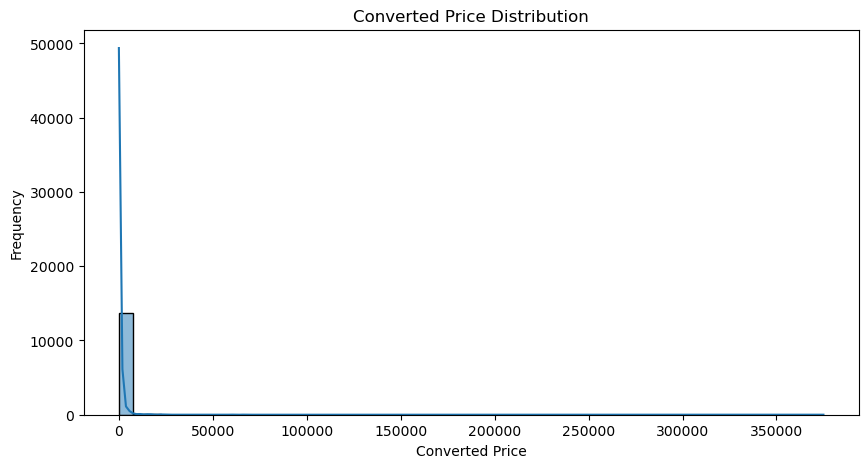

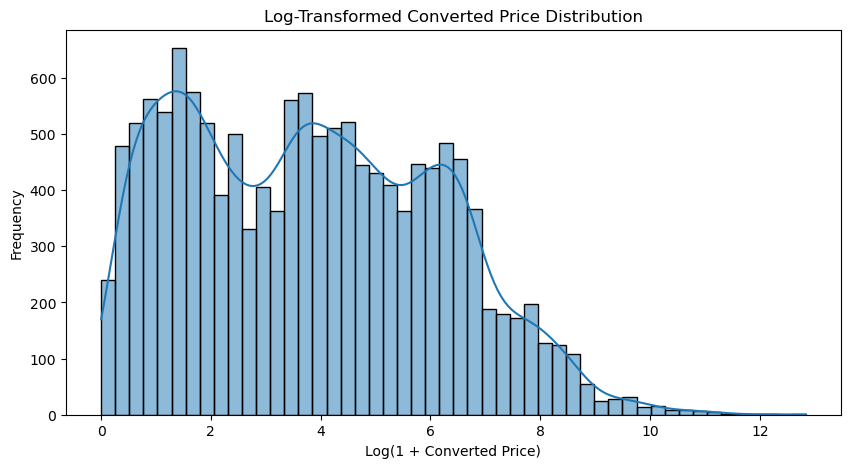

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# converted_price 분포 시각화
plt.figure(figsize=(10,5))
sns.histplot(data['converted_price'], bins=50, kde=True)
plt.title('Converted Price Distribution')
plt.xlabel('Converted Price')
plt.ylabel('Frequency')
plt.show()

# 로그 변환 후 분포 시각화
plt.figure(figsize=(10,5))
sns.histplot(np.log1p(data['converted_price']), bins=50, kde=True)
plt.title('Log-Transformed Converted Price Distribution')
plt.xlabel('Log(1 + Converted Price)')
plt.ylabel('Frequency')
plt.show()

In [7]:
from sklearn.preprocessing import OneHotEncoder

# '견적화폐' 컬럼을 OneHotEncoder를 통해 인코딩
currency_ohe = OneHotEncoder(sparse_output=False) 
currency_encoded = currency_ohe.fit_transform(data[['견적화폐']])

In [8]:
import numpy as np
data['converted_price_log'] = np.log1p(data['converted_price'])  # 로그 변환된 가격


In [9]:
# 레이블 인코딩
machinery_label_encoder = LabelEncoder()
y_machinery= machinery_label_encoder.fit_transform(data['Machinery'])

assembly_label_encoder = LabelEncoder()
y_assembly = assembly_label_encoder.fit_transform(data['Assembly'])

In [10]:
# train_test split 을 위해 하나로 모으고, 분할하고 다시 텍스트랑 추가피쳐로 분리해줄거임 

# 1. 텍스트 + 추가 피처 결합
X = np.concatenate([
    data['combined_text'].values.reshape(-1, 1),  # 2차원 배열로 바꿔서 결합해줌 
    currency_encoded, 
    data['converted_price_log'].values.reshape(-1, 1)  # 통일한단가
], axis=1)

X_train_val, X_test, y_train_val_machinery, y_test_machinery, y_train_val_assembly, y_test_assembly = train_test_split(
    X, y_machinery, y_assembly, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_assembly)  # stratify는 주로 메인 레이블 기준으로 설정

X_train, X_val, y_train_machinery, y_val_machinery, y_train_assembly, y_val_assembly = train_test_split(
    X_train_val, y_train_val_machinery, y_train_val_assembly, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_train_val_assembly)  # 다시 stratify 기준으로 설정

# 크기 확인
print(f"combined_text shape: {data['combined_text'].shape}")
print(f"currency_encoded shape: {currency_encoded.shape}")
print(f"converted_price shape: {data['converted_price'].shape}")
print(f"X shape after concatenation: {X.shape}")

print(f"X_train size: {X_train.shape}")
print(f"X_val size: {X_val.shape}")
print(f"X_test size: {X_test.shape}")


combined_text shape: (13882,)
currency_encoded shape: (13882, 4)
converted_price shape: (13882,)
X shape after concatenation: (13882, 6)
X_train size: (10029, 6)
X_val size: (1770, 6)
X_test size: (2083, 6)


In [11]:
# 텍스트 분리
train_combined_text = X_train[:, 0]
val_combined_text = X_val[:, 0]
test_combined_text = X_test[:, 0]

# 추가 피처 분리 (currency_encoded와 로그 변환된 가격)
train_extra_features = X_train[:, 1:]
val_extra_features = X_val[:, 1:]
test_extra_features = X_test[:, 1:]

# 값이 float으로 변환되도록 nan 처리
train_extra_features = np.nan_to_num(train_extra_features, nan=0.0).astype(float)
val_extra_features = np.nan_to_num(val_extra_features, nan=0.0).astype(float)
test_extra_features = np.nan_to_num(test_extra_features, nan=0.0).astype(float)

# 스케일링 적용
scaler = StandardScaler()
train_extra_features = scaler.fit_transform(train_extra_features)
val_extra_features = scaler.transform(val_extra_features)
test_extra_features = scaler.transform(test_extra_features)



In [12]:
# Torch Tensor로 변환 후 디바이스 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_extra_features_tensor = torch.tensor(train_extra_features, dtype=torch.float32).to(device)
val_extra_features_tensor = torch.tensor(val_extra_features, dtype=torch.float32).to(device)
test_extra_features_tensor = torch.tensor(test_extra_features, dtype=torch.float32).to(device)


C:\Users\User\AppData\Local\Temp\ipykernel_5080\840112757.py:3: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  train_extra_features_tensor = torch.tensor(train_extra_features, dtype=torch.float32).to(device)


In [13]:
# BERT 토크나이저 (텍스트처리)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

C:\Users\User\anaconda3\envs\ship\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
# X중 텍스트만 BERT 입력 형식으로 변환
def encode_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')

train_encodings = encode_data(train_combined_text)
val_encodings = encode_data(val_combined_text)
test_encodings = encode_data(test_combined_text)


In [15]:
train_machinery_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_extra_features_tensor,
    torch.tensor(y_train_machinery, dtype=torch.long).to(device)  # Machinery 레이블
)

val_machinery_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    val_extra_features_tensor,
    torch.tensor(y_val_machinery, dtype=torch.long).to(device)
)

test_machinery_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_extra_features_tensor,
    torch.tensor(y_test_machinery, dtype=torch.long).to(device)
)

In [16]:
print(f"y_train size: {y_train_machinery.shape}")
print(f"y_val size: {y_val_machinery.shape}")
print(f"y_test size: {y_test_machinery.shape}")


y_train size: (10029,)
y_val size: (1770,)
y_test size: (2083,)


In [17]:
# 3. DataLoader 생성
from torch.utils.data import DataLoader

batch_size = 16

train_loader_machinery = DataLoader(train_machinery_dataset, batch_size=batch_size, shuffle=True)
val_loader_machinery  = DataLoader(val_machinery_dataset, batch_size=batch_size, shuffle=False)
test_loader_machinery = DataLoader(test_machinery_dataset, batch_size=batch_size, shuffle=False)

In [18]:
class BertForMachinery(nn.Module):
    def __init__(self, num_machinery_labels, extra_features_dim):
        super(BertForMachinery, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc1 = nn.Linear(773, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.machinery_classifier = nn.Linear(256, num_machinery_labels)

    def forward(self, input_ids, attention_mask, extra_features):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        
        if extra_features.dim() == 1:
            extra_features = extra_features.unsqueeze(1)
        
        machinery_combined_features = torch.cat((pooled_output, extra_features), dim=1)
        x = self.fc1(machinery_combined_features)
        x = self.relu(x)
        x = self.dropout(x)
        machinery_outputs = self.machinery_classifier(x)
        
        return machinery_outputs

In [19]:
import torch
torch.cuda.empty_cache()

In [20]:
# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
machinery_model = BertForMachinery(num_machinery_labels=len(machinery_label_encoder.classes_), extra_features_dim=10) 
machinery_model.to(device)


BertForMachinery(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [21]:
# 옵티마이저 및 학습률 스케줄러 설정
optimizer_machinery = AdamW(machinery_model.parameters(), lr=2e-5)
loss_fn_machinery=torch.nn.CrossEntropyLoss()

C:\Users\User\anaconda3\envs\ship\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
def train_machinery(model, dataloader, optimizer, device, loss_fn):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        input_ids, attention_mask, extra_features, labels = [b.to(device) for b in batch]  # 순서 수정
        
        if labels.dim() > 1:
            labels = labels.squeeze()

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, extra_features=extra_features)
        labels = labels.to(torch.int64)  # CrossEntropyLoss에 맞게 변환
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)


In [23]:
import torch.nn.functional as F

# 평가 함수 - logits-62개짜리 각각의 자신감
def evaluate_machinery(model, dataloader, device, loss_fn_machinery):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    machinery_predictions = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids, attention_mask, extra_features, labels = [b.to(device) for b in batch]
            
            # 모델 예측
            outputs = model(input_ids, attention_mask=attention_mask, extra_features=extra_features)
            
            # Loss 계산
            loss = loss_fn_machinery(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)  # softmax 없이 직접 logits에서 최대값 클래스 예측
            
            # 예측값을 저장
            machinery_predictions.append(predicted.cpu().numpy())  # 리스트에 추가
            
            # 정확도 계산
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    machinery_predictions = np.concatenate(machinery_predictions, axis=0)  
    avg_loss = total_loss / len(dataloader)
    
    return avg_loss, accuracy, machinery_predictions

In [24]:
import torch
torch.cuda.empty_cache()

In [46]:
# Machinery 모델 학습 실행
num_epochs = 15
best_val_acc_machinery = 0
patience = 3
trigger_times = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Machinery 모델 학습
    train_loss_machinery = train_machinery(
        machinery_model, 
        train_loader_machinery, 
        optimizer_machinery, 
        device, 
        loss_fn_machinery
    )
    
    # Machinery 모델 평가
    val_loss_machinery, val_acc_machinery, val_preds_machinery = evaluate_machinery(
        machinery_model, 
        val_loader_machinery, 
        device, 
        loss_fn_machinery
    )
    test_loss_machinery, test_acc_machinery, test_preds_machinery = evaluate_machinery(
        machinery_model, 
        test_loader_machinery, 
        device, 
        loss_fn_machinery
    )
    
    print(f"Machinery - Train Loss: {train_loss_machinery:.4f}, Val Loss: {val_loss_machinery:.4f}, Val Acc: {val_acc_machinery:.4f}, Test Acc: {test_acc_machinery:.4f}")
    
    # Early Stopping for Machinery
    if val_acc_machinery > best_val_acc_machinery:
        best_val_acc_machinery = val_acc_machinery
        trigger_times = 0
        torch.save(machinery_model.state_dict(), "2_best_machinery_model.pth")
    else:
        trigger_times += 1
        print(f"Trigger Times (Machinery): {trigger_times}")
        if trigger_times >= patience:
            print("Early stopping for Machinery!")
            break

# 최종 테스트 성능 평가
final_test_loss_machinery, final_test_acc_machinery, final_machinery_predictions = evaluate_machinery(
    machinery_model, 
    test_loader_machinery, 
    device, 
    loss_fn_machinery
)
print(f"Final Test Accuracy (Machinery): {final_test_acc_machinery:.4f}")
torch.save(machinery_model.state_dict(), "2_best_machinery_model.pth")


Epoch 1/15


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:11<00:00, 11.79it/s]


Machinery - Train Loss: 1.8879, Val Loss: 1.3840, Val Acc: 0.6559, Test Acc: 0.6539
Epoch 2/15


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:11<00:00, 11.76it/s]


Machinery - Train Loss: 1.2781, Val Loss: 1.1180, Val Acc: 0.6966, Test Acc: 0.6985
Epoch 3/15


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:11<00:00, 11.73it/s]


Machinery - Train Loss: 1.0401, Val Loss: 0.9283, Val Acc: 0.7373, Test Acc: 0.7316
Epoch 4/15


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:11<00:00, 11.75it/s]


Machinery - Train Loss: 0.8761, Val Loss: 0.8312, Val Acc: 0.7599, Test Acc: 0.7724
Epoch 5/15


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:11<00:00, 11.75it/s]


Machinery - Train Loss: 0.7660, Val Loss: 0.7654, Val Acc: 0.7842, Test Acc: 0.7840
Epoch 6/15


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:11<00:00, 11.76it/s]


Machinery - Train Loss: 0.6751, Val Loss: 0.6915, Val Acc: 0.8017, Test Acc: 0.8003
Epoch 7/15


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:11<00:00, 11.51it/s]


Machinery - Train Loss: 0.5931, Val Loss: 0.6463, Val Acc: 0.8090, Test Acc: 0.8128
Epoch 8/15


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:11<00:00, 11.79it/s]


Machinery - Train Loss: 0.5324, Val Loss: 0.5988, Val Acc: 0.8119, Test Acc: 0.8080
Epoch 9/15


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:10<00:00, 11.96it/s]


Machinery - Train Loss: 0.4904, Val Loss: 0.5888, Val Acc: 0.8192, Test Acc: 0.8233
Epoch 10/15


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:10<00:00, 11.96it/s]


Machinery - Train Loss: 0.4474, Val Loss: 0.5858, Val Acc: 0.8232, Test Acc: 0.8233
Epoch 11/15


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:10<00:00, 11.96it/s]


Machinery - Train Loss: 0.4231, Val Loss: 0.5542, Val Acc: 0.8322, Test Acc: 0.8296
Epoch 12/15


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:10<00:00, 11.97it/s]


Machinery - Train Loss: 0.3929, Val Loss: 0.5485, Val Acc: 0.8350, Test Acc: 0.8363
Epoch 13/15


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:10<00:00, 11.97it/s]


Machinery - Train Loss: 0.3678, Val Loss: 0.5360, Val Acc: 0.8350, Test Acc: 0.8291
Trigger Times (Machinery): 1
Epoch 14/15


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:11<00:00, 11.75it/s]


Machinery - Train Loss: 0.3492, Val Loss: 0.5802, Val Acc: 0.8311, Test Acc: 0.8257
Trigger Times (Machinery): 2
Epoch 15/15


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:11<00:00, 11.64it/s]


Machinery - Train Loss: 0.3401, Val Loss: 0.5406, Val Acc: 0.8379, Test Acc: 0.8349


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:11<00:00, 11.77it/s]


Final Test Accuracy (Machinery): 0.8349


### 전이 학습으로 Assembly 모델

> 프로토타입-1개 최상위 예측 가져오도록 함

In [25]:
# Machinery 모델 로드 및 가중치 고정
num_machinery_labels = len(np.unique(y_machinery))
extra_features_dim = train_extra_features.shape[1]

machinery_model = BertForMachinery(
    num_machinery_labels=num_machinery_labels, 
    extra_features_dim=extra_features_dim
).to(device)

# 사전에 학습된 모델 가중치 로드
machinery_model.load_state_dict(torch.load("2_best_machinery_model.pth"))
machinery_model.eval()

C:\Users\User\AppData\Local\Temp\ipykernel_5080\3444092418.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  machinery_model.load_state_dict(torch.load("2_best_machinery_

BertForMachinery(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [26]:
# Top-K 예측값과 확률값 함께 가져오기 함수
def get_top_k_machinery_predictions_with_probs(model, dataloader, k=3):
    model.eval()
    top_k_predictions = []
    top_k_probs = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating Top-K Machinery Predictions"):
            input_ids, attention_mask, extra_features, _ = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask, extra_features)

            # 상위 K개의 예측값과 확률 가져오기
            probs = F.softmax(outputs, dim=1)
            topk_prob, topk_predicted = torch.topk(probs, k, dim=1)
            top_k_predictions.append(topk_predicted.cpu())
            top_k_probs.append(topk_prob.cpu())
    return torch.cat(top_k_predictions, dim=0), torch.cat(top_k_probs, dim=0)


In [27]:
import torch
torch.cuda.empty_cache()

In [28]:
# Machinery 예측값 생성
train_loader_machinery = DataLoader(
    train_machinery_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

val_loader_machinery = DataLoader(
    val_machinery_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

test_loader_machinery = DataLoader(
    test_machinery_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

# 예측 생성 (Top-3)
train_machinery_predictions_top_3, train_machinery_probs_top_3 = get_top_k_machinery_predictions_with_probs(
    machinery_model, 
    train_loader_machinery, 
    k=3
)

val_machinery_predictions_top_3, val_machinery_probs_top_3 = get_top_k_machinery_predictions_with_probs(
    machinery_model, 
    val_loader_machinery, 
    k=3
)

test_machinery_predictions_top_3, test_machinery_probs_top_3 = get_top_k_machinery_predictions_with_probs(
    machinery_model, 
    test_loader_machinery, 
    k=3
)

Generating Top-K Machinery Predictions:   0%|                                                  | 0/627 [00:00<?, ?it/s]C:\Users\User\anaconda3\envs\ship\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Generating Top-K Machinery Predictions: 100%|████████████████████████████████████████| 131/131 [00:10<00:00, 11.92it/s]


In [29]:
# Machinery 모델을 GPU에서 CPU로 이동 또는 메모리 해제
machinery_model.cpu()  # CPU로 이동
del machinery_model    # 메모리에서 해제
torch.cuda.empty_cache()  # GPU 캐시 비우기

In [30]:
def create_assembly_dataset(encodings, extra_features, topk_predictions, topk_probs, labels):
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    extra_features_tensor = torch.tensor(extra_features, dtype=torch.float)
    topk_predictions_tensor = topk_predictions  # 이미 torch.Tensor 형식
    topk_probs_tensor = topk_probs  # 이미 torch.Tensor 형식
    labels_tensor = torch.tensor(labels, dtype=torch.long).to(device)
    return TensorDataset(input_ids, attention_mask, extra_features_tensor, topk_predictions_tensor, topk_probs_tensor, labels_tensor)


In [31]:
# Assembly 데이터셋에 Top-3 예측값과 확률 추가
train_assembly_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_extra_features_tensor,
    train_machinery_predictions_top_3,   # Top-3 예측값 추가
    train_machinery_probs_top_3,         # Top-3 확률값 추가
    torch.tensor(y_train_assembly, dtype=torch.long).to(device)  # Assembly 레이블
)

val_assembly_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    val_extra_features_tensor,
    val_machinery_predictions_top_3,     # Top-3 예측값 추가
    val_machinery_probs_top_3,           # Top-3 확률값 추가
    torch.tensor(y_val_assembly, dtype=torch.long).to(device)
)

test_assembly_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_extra_features_tensor,
    test_machinery_predictions_top_3,    # Top-3 예측값 추가
    test_machinery_probs_top_3,          # Top-3 확률값 추가
    torch.tensor(y_test_assembly, dtype=torch.long).to(device)
)


In [32]:
# DataLoader 생성
batch_size = 8
train_loader_assembly = DataLoader(train_assembly_dataset, batch_size=batch_size, shuffle=True)
val_loader_assembly  = DataLoader(val_assembly_dataset, batch_size=batch_size, shuffle=False)
test_loader_assembly = DataLoader(test_assembly_dataset, batch_size=batch_size, shuffle=False)

In [33]:
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight

# FocalLoss 정의 (클래스 불균형 처리)
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [34]:
num_assembly_labels = len(assembly_label_encoder.classes_)
machinery_output_dim = 62 

In [35]:
from transformers import DistilBertModel
# EnhancedAssemblyModel 정의
class EnhancedAssemblyModel(nn.Module):
    def __init__(self, num_assembly_labels, extra_features_dim, dropout_rate=0.3):
        super(EnhancedAssemblyModel, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        
        # Multihead Attention 추가
        self.attention = nn.MultiheadAttention(embed_dim=768, num_heads=2, dropout=dropout_rate)
        
        combined_dim = 768 + 3 + 3 + extra_features_dim
        self.fc1 = nn.Linear(combined_dim, 256)
        self.batchnorm = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, num_assembly_labels)
    
    def forward(self, input_ids, attention_mask, machinery_predictions_top_k, machinery_probs_top_k, extra_features):
        # BERT 출력
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.last_hidden_state[:,0,:]  # [CLS] token 사용
        
        # Attention Mechanism 적용
        pooled_output = pooled_output.unsqueeze(0)  # (1, batch_size, 768)
        attn_output, _ = self.attention(pooled_output, pooled_output, pooled_output)
        attn_output = attn_output.squeeze(0)  # (batch_size, 768)
        
        # 추가적인 특징들과 결합
        combined_features = torch.cat((
            attn_output, 
            machinery_predictions_top_k.float(), 
            machinery_probs_top_k.float(), 
            extra_features.float()
        ), dim=1)
        
        # Fully connected layers
        x = self.fc1(combined_features)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.dropout(x)
        assembly_outputs = self.fc2(x)
        
        return assembly_outputs

In [36]:
import torch
torch.cuda.empty_cache()

In [37]:
# Assembly 모델 초기화
num_assembly_labels = len(np.unique(y_train_assembly))
extra_features_dim = train_extra_features.shape[1]

assembly_model = EnhancedAssemblyModel(
    num_assembly_labels=num_assembly_labels, 
    extra_features_dim=extra_features_dim,
    dropout_rate=0.3
).to(device)


In [38]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
# 클래스 가중치 계산
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_assembly),
    y=y_train_assembly
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# 손실 함수 설정
criterion = FocalLoss(alpha=1, gamma=2, reduction='mean')  # 또는
# criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer 및 Scheduler 설정
optimizer = AdamW(assembly_model.parameters(), lr=2e-5, weight_decay=0.01)
num_epochs = 5
total_steps = len(train_loader_assembly) * num_epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

C:\Users\User\anaconda3\envs\ship\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [39]:
import torch
torch.cuda.empty_cache()

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델을 GPU로 이동
assembly_model.to(device)

EnhancedAssemblyModel(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [41]:
# Assembly 모델 학습 및 평가 함수 정의
def train_assembly(model, dataloader, optimizer, device, loss_fn):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training Assembly"):
        input_ids, attention_mask, extra_features, machinery_predictions_top_3, machinery_probs_top_3, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        extra_features = extra_features.to(device)
        machinery_predictions_top_3 = machinery_predictions_top_3.to(device)
        machinery_probs_top_3 = machinery_probs_top_3.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Assembly 모델 예측: machinery_predictions_top_3 및 machinery_probs_top_3 추가
        outputs = model(
            input_ids, 
            attention_mask, 
            machinery_predictions_top_3, 
            machinery_probs_top_3, 
            extra_features
        )
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    return total_loss / len(dataloader)

In [42]:
def evaluate_assembly(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_samples = 0
    all_predictions = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Assembly"):
            input_ids, attention_mask, extra_features, machinery_predictions_top_3, machinery_probs_top_3, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            extra_features = extra_features.to(device)
            machinery_predictions_top_3 = machinery_predictions_top_3.to(device)
            machinery_probs_top_3 = machinery_probs_top_3.to(device)
            labels = labels.to(device)
            
            # Assembly 모델 예측
            outputs = model(
                input_ids, 
                attention_mask, 
                machinery_predictions_top_3, 
                machinery_probs_top_3, 
                extra_features
            )
            
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            
            all_predictions.append(predicted.cpu().numpy())
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    
    accuracy = total_correct / total_samples
    all_predictions = np.concatenate(all_predictions, axis=0)
    return accuracy, all_predictions

In [43]:
import torch
torch.cuda.empty_cache()

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import copy
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report


# Assembly 모델 학습 루프
best_f1 = 0
best_model_state = copy.deepcopy(assembly_model.state_dict())
patience = 2
patience_counter = 0

for epoch in range(num_epochs):
    # Training
    assembly_model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader_assembly, desc=f"Training Epoch {epoch+1}"):
        input_ids, attention_mask, extra_features, machinery_predictions_top_3, machinery_probs_top_3, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        extra_features = extra_features.to(device)
        machinery_predictions_top_3 = machinery_predictions_top_3.to(device)
        machinery_probs_top_3 = machinery_probs_top_3.to(device)
        labels = labels.to(device)
        
        # Machinery 예측값 가져오기 (이미 Top-K 예측값이 데이터셋에 포함되어 있으므로, 추가 예측 필요 없음)
        # 기존 코드에서는 다시 Machinery 모델을 호출했으나, 이미 Top-K 예측값을 포함하므로 생략
        # 만약 다시 Machinery 모델을 호출해야 한다면 아래 주석 해제
        # with torch.no_grad():
        #     machinery_outputs = machinery_model(input_ids, attention_mask, extra_features)
        #     machinery_probs = F.softmax(machinery_outputs, dim=1)
        #     topk_prob, topk_predicted = torch.topk(machinery_probs, k=3, dim=1)
        
        optimizer.zero_grad()
        
        # Assembly 모델의 출력
        outputs = assembly_model(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            machinery_predictions_top_k=machinery_predictions_top_3, 
            machinery_probs_top_k=machinery_probs_top_3, 
            extra_features=extra_features
        )
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader_assembly)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")
    
    # Validation
    assembly_model.eval()
    total_val_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader_assembly, desc="Validation"):
            input_ids, attention_mask, extra_features, machinery_predictions_top_3, machinery_probs_top_3, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            extra_features = extra_features.to(device)
            machinery_predictions_top_3 = machinery_predictions_top_3.to(device)
            machinery_probs_top_3 = machinery_probs_top_3.to(device)
            labels = labels.to(device)
            
            # Assembly 모델의 출력
            outputs = assembly_model(
                input_ids=input_ids, 
                attention_mask=attention_mask, 
                machinery_predictions_top_k=machinery_predictions_top_3, 
                machinery_probs_top_k=machinery_probs_top_3, 
                extra_features=extra_features
            )
            
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = total_val_loss / len(val_loader_assembly)
    metrics = {
        'f1': f1_score(all_labels, all_preds, average='weighted'),
        'precision': precision_score(all_labels, all_preds, average='weighted'),
        'recall': recall_score(all_labels, all_preds, average='weighted')
    }
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, F1: {metrics['f1']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}")
    
    # Early Stopping 및 최적 모델 저장
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_model_state = copy.deepcopy(assembly_model.state_dict())
        patience_counter = 0
        torch.save(best_model_state, "2_best_assembly_model.pth")
        print(f"Best model saved with F1: {best_f1:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# 최적 모델 로드
assembly_model.load_state_dict(best_model_state)

Training Epoch 1: 100%|████████████████████████████████████████████████████████████| 1254/1254 [02:11<00:00,  9.51it/s]


Epoch 1/5, Training Loss: 4.6122


Validation: 100%|████████████████████████████████████████████████████████████████████| 222/222 [00:05<00:00, 37.05it/s]
C:\Users\User\anaconda3\envs\ship\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5, Validation Loss: 3.8111, F1: 0.1558, Precision: 0.1563, Recall: 0.2503
Best model saved with F1: 0.1558


Training Epoch 2: 100%|████████████████████████████████████████████████████████████| 1254/1254 [02:12<00:00,  9.44it/s]


Epoch 2/5, Training Loss: 3.7703


Validation: 100%|████████████████████████████████████████████████████████████████████| 222/222 [00:06<00:00, 36.10it/s]
C:\Users\User\anaconda3\envs\ship\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/5, Validation Loss: 3.1150, F1: 0.2843, Precision: 0.2844, Recall: 0.3718
Best model saved with F1: 0.2843


Training Epoch 3: 100%|████████████████████████████████████████████████████████████| 1254/1254 [02:12<00:00,  9.46it/s]


Epoch 3/5, Training Loss: 3.3365


Validation: 100%|████████████████████████████████████████████████████████████████████| 222/222 [00:06<00:00, 36.77it/s]
C:\Users\User\anaconda3\envs\ship\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/5, Validation Loss: 2.7508, F1: 0.3492, Precision: 0.3673, Recall: 0.4328
Best model saved with F1: 0.3492


Training Epoch 4:   5%|██▊                                                           | 57/1254 [00:06<02:09,  9.27it/s]


KeyboardInterrupt: 

In [ ]:
test_loader_assembly = DataLoader(test_assembly_dataset, batch_size=batch_size, shuffle=False)

assembly_model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader_assembly, desc="Testing"):
        input_ids, attention_mask, extra_features, machinery_predictions_top_3, machinery_probs_top_3, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        extra_features = extra_features.to(device)
        machinery_predictions_top_3 = machinery_predictions_top_3.to(device)
        machinery_probs_top_3 = machinery_probs_top_3.to(device)
        labels = labels.to(device)
        
        # Assembly 모델의 출력
        outputs = assembly_model(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            machinery_predictions_top_k=machinery_predictions_top_3, 
            machinery_probs_top_k=machinery_probs_top_3, 
            extra_features=extra_features
        )
        
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_test_preds.extend(preds)
        all_test_labels.extend(labels.cpu().numpy())

# 혼동 행렬 시각화
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Assembly Model')
plt.show()

# 클래스별 성능 지표 출력
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds))